# Importing Libraries

In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np 
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import joblib
from sklearn.utils import shuffle
%matplotlib inline

# Pre processing Data

## Dimensional Reduction based on Domain Knowledge and Model Necessities

In [67]:
bulan = 'JUN JUL AGT'
bulan = list(bulan.split())
minggu = [1,2,3,4]
so= pd.DataFrame()
for i in bulan:
    for j in minggu:
        df = pd.read_csv(f'{i}/{j}.csv')
        df = df[['SO Number','Transaction Date','Sales (Harga Jual)','Web Payment Status','Total Sales','Kode Motherstore','PLU','Deskripsi','Qty']]
        df = df[df['Web Payment Status']=='LUNAS']
        so = pd.concat([so,df],axis=0)

In [68]:
so.head()

,SO Number,Transaction Date,Sales (Harga Jual),Web Payment Status,Total Sales,Kode Motherstore,PLU,Deskripsi,Qty
0,A1167SDHB,6/1/2020,33500.0,LUNAS,25000.0,TWNC,20083461,"So Good,Paha & Dada Ayam Potong Bumbu Kuning 4...",1
1,A1167SDHB,6/1/2020,32500.0,LUNAS,39800.0,TWNC,20101652,"Palmolive,Shower Milk & Honey Rich Moisture 40...",2
6,A1167TNMH,6/1/2020,5000.0,LUNAS,0.0,TJK8,10036492,"Biaya,Jasa Kirim",1
7,A1167TNMH,6/1/2020,29900.0,LUNAS,26900.0,TJK8,20007060,"Greenfields,Fresh Milk Pasteurisasi Full Cream...",1
8,A1167TNMH,6/1/2020,15000.0,LUNAS,30000.0,TJK8,20003591,"Sari Roti,Roti Tawar Kupas Extra Kalsium 200G Pck",2


In [69]:
so.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7078240 entries, 0 to 716854
Data columns (total 9 columns):
SO Number             7078240 non-null object
Transaction Date      7078240 non-null object
Sales (Harga Jual)    7078240 non-null float64
Web Payment Status    7078240 non-null object
Total Sales           7078240 non-null float64
Kode Motherstore      7033615 non-null object
PLU                   7078240 non-null int64
Deskripsi             7078240 non-null object
Qty                   7078240 non-null int64
dtypes: float64(2), int64(2), object(5)
memory usage: 540.0+ MB


## Dropping rows where Kode Motherstore is not available

In [70]:
so= so[~so['Kode Motherstore'].isnull()]

In [71]:
so['SO Number'].nunique()

1527842

In [72]:
so['Find'] = so['Deskripsi'].str.find('Biaya')
so[~so['Find']==-1].shape[0]

855088

In [73]:
(so[~so['Find']==-1].shape[0])/(so['SO Number'].nunique())*100

55.96704371263521

In [74]:
so = so[so['Find']==-1]

## Adding 'Category' Feature

In [75]:
catcode = pd.read_csv('catcode.csv')
catcode.sample(5)

,PLU,Name,Description,Product Brand,Tanggal Mulai Tayang,Tanggal Akhir Tayang,Product Flag,Flag Product,Is Deleted,Is Displayed,...,Mega Sale Sale Item,Stock On Hand,Stock Reserved,Stock Available,Adjustment Weight,Overall Rating,Title,Category,Permalink,Unnamed: 30
17773,20105829,YAYASAN PENDIDIKAN,"PEMBAYARAN,YAYASAN PENDIDIKAN PELITA HARAPAN",Pembayaran,08-Jul-2020,08-Jul-2055,Plaza,DP,False,No,...,No,0,0,0,0,NaN,NaN,NaN,yayasan-pendidikan-1,NaN
7458,20044329,HOT COCOA INDULGENCE,"DELFI,HOT COCOA INDULGENCE 20x25g BAG",Delfi,06-Apr-2015,31-Dec-2055,Plaza,DP,False,Yes,...,No,23,0,23,0,NaN,Delfi Hot Cocoa Indulgence 20x25G,Coklat Bubuk dan Kremer,hot-cocoa-indulgence-1,NaN
24700,20080326,PREMIUM PANTS 22'S,"GOO.N,PREMIUM PANTS 22'S EXTRALARGE BAG",Goo.N,09-Aug-2017,09-Aug-2055,Plaza,DP,True,No,...,No,0,0,0,0,NaN,NaN,Popok Bayi,premium-pants-22s,NaN
11187,20103310,OLIVE OIL EXTRA LIGHT,"FILIPPO BERIO,OLIVE OIL EXTRA LIGHT 250mL BTL",Filippo Berio,12-Jun-2020,12-Jun-2055,Plaza,DP,False,Yes,...,No,16,0,16,0,NaN,Filippo Berio Olive Oil Extra Light 250Ml,Cooking Oil,olive-oil-extra-light,NaN
4491,20062933,COLOR ICON EYESHADOW TRIO,"WET N WILD,COLOR ICON EYESHADOW TRIO WALKING O...",Wet N Wild,09-Sep-2015,09-Sep-2055,Plaza,BP,False,No,...,No,3,0,3,0,NaN,Wet N Wild Color Icon Eyeshadow Trio Walking O...,Mata,color-icon-eyeshadow-trio-1,NaN


In [76]:
so = so.merge(catcode[['PLU','Category']],how='left',on='PLU')

In [77]:
so.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6178527 entries, 0 to 6178526
Data columns (total 11 columns):
SO Number             6178527 non-null object
Transaction Date      6178527 non-null object
Sales (Harga Jual)    6178527 non-null float64
Web Payment Status    6178527 non-null object
Total Sales           6178527 non-null float64
Kode Motherstore      6178527 non-null object
PLU                   6178527 non-null int64
Deskripsi             6178527 non-null object
Qty                   6178527 non-null int64
Find                  6178527 non-null int64
Category              6177295 non-null object
dtypes: float64(2), int64(3), object(6)
memory usage: 565.7+ MB


## Filling missing 'Category'

In [78]:
so[so['Category'].isnull()]['Deskripsi'].value_counts()

Sprite,Soft Drink Waterlymon 425Ml Pet      992
Super O2,Air Mineral Sportivo  600Ml Btl    240
Name: Deskripsi, dtype: int64

In [79]:
cattree = pd.read_csv('category_tree.csv')
cattree.sample(5)

,Name,Full Name,Permalink,Level,Sort Order,Product Total,Support Comparison,Support Filter By Price,Support Filter By Brand,Is Deleted,Unnamed: 10
920,Tank Tops,i-Fashion > Fashion > Fashion Ibu & Anak > Pa...,tank-tops-1,5,0,0,False,False,False,False,NaN
411,Aksesoris Pria,i-Fashion > Fashion > Fashion Pria > Aksesoris...,men-accessories,3,4,58,False,False,False,False,NaN
78,Plus Size,i-Fashion > Women's Fashion > Plus Size,plus-size,2,1,0,False,False,False,False,NaN
245,TV & Video,i-Tech > Gadget & Elektronik > Elektronik > TV...,tv--video,3,0,3,False,False,False,True,NaN
449,Pakaian Dalam Pria,i-Fashion > Fashion > Fashion Pria > Pakaian D...,pakaian-dalam-pria,3,5,37,False,False,False,False,NaN


In [80]:
cattree[cattree['Name'].str.find('Bag')>0]['Name'].value_counts()

Sling Bags           3
Saddle Bags          1
Travel Bags          1
Messenger Bags       1
Hobo Bags            1
Tote Bags            1
Laptop Bags          1
Camera Bag & Case    1
Satchel Bags         1
Name: Name, dtype: int64

In [81]:
so[so['Deskripsi'].str.find('pri')>0]['Category'].value_counts()

Minuman Ringan    9406
Cokelat            993
Buah Segar         338
Permen             324
Mainan              26
Name: Category, dtype: int64

In [82]:
so[so['Deskripsi'].str.find('izone')>0]['Category'].value_counts()

New Arrival       654
Minuman Ringan    573
Name: Category, dtype: int64

In [83]:
so[so['Deskripsi'].str.find('anduk')>0]['Category'].value_counts()

Tisu Toilet                                      2893
Perlengkapan Dan Alat Kebersihan Rumah Tangga     675
Handuk                                            502
Name: Category, dtype: int64

In [84]:
so[so['Category'].str.find('ainan')>0]['Category'].value_counts()

Mainan    500
Name: Category, dtype: int64

In [85]:
def filling_missing_category(x):
    if x['Deskripsi'].strip() == 'Sprite,Soft Drink Waterlymon 425Ml Pet':
        return 'Minuman Ringan'
    elif x['Deskripsi'].strip() == 'Super O2,Air Mineral Sportivo  600Ml Btl':
        return 'Minuman Ringan'
    elif x['Deskripsi'].strip() == 'KRAFT,OREO THINS TOTE BAG':
        return 'Tote Bags'
    elif x['Deskripsi'].strip() == 'MAMY POKO,HANDUK':
        return 'Handuk'
    elif x['Deskripsi'].strip() == 'POKEMON,GAME KARTU HADIAH':
        return 'Mainan'
    else:
        return x['Category']    


In [86]:
so['Kategori'] = so.apply(filling_missing_category,axis=1)
so.drop('Category',axis=1,inplace=True)

In [87]:
so.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6178527 entries, 0 to 6178526
Data columns (total 11 columns):
SO Number             6178527 non-null object
Transaction Date      6178527 non-null object
Sales (Harga Jual)    6178527 non-null float64
Web Payment Status    6178527 non-null object
Total Sales           6178527 non-null float64
Kode Motherstore      6178527 non-null object
PLU                   6178527 non-null int64
Deskripsi             6178527 non-null object
Qty                   6178527 non-null int64
Find                  6178527 non-null int64
Kategori              6178527 non-null object
dtypes: float64(2), int64(3), object(6)
memory usage: 565.7+ MB


## Levelling 'Category'

In [88]:
def category_level(word):
    return len(list(word.split(">")))

In [89]:
cattree['Name']= cattree['Name'].str.strip()
cattree.drop_duplicates(subset='Name',keep='first',inplace=True)
cattree['Level'] = cattree['Full Name'].apply(category_level)

In [90]:
so.rename(columns={'Kategori':'Name'},inplace=True)
so['Name'] = so['Name'].str.strip()

In [91]:
so = so.merge(cattree[['Name','Level']],on='Name',how='left')
so['Level'].value_counts()

4    3982643
5    1451425
3     563329
2      98017
6      67901
1      15212
Name: Level, dtype: int64

In [92]:
def levelling(cattree):
    if cattree['Level']>4:
        return list(cattree['Full Name'].split(">"))[2].strip()
    else :
        return cattree['Name']

In [93]:
cattree['New Category'] = cattree.apply(levelling,axis=1)

In [94]:
so = so.merge(cattree[['Name','New Category']],on='Name',how='left')

In [95]:
so.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6178527 entries, 0 to 6178526
Data columns (total 13 columns):
SO Number             6178527 non-null object
Transaction Date      6178527 non-null object
Sales (Harga Jual)    6178527 non-null float64
Web Payment Status    6178527 non-null object
Total Sales           6178527 non-null float64
Kode Motherstore      6178527 non-null object
PLU                   6178527 non-null int64
Deskripsi             6178527 non-null object
Qty                   6178527 non-null int64
Find                  6178527 non-null int64
Name                  6178527 non-null object
Level                 6178527 non-null int64
New Category          6178527 non-null object
dtypes: float64(2), int64(4), object(7)
memory usage: 659.9+ MB


In [96]:
# so.groupby('SO Number').describe()

# Making Product Master

In [97]:
# def max_price (x):
#     return so[so['Deskripsi']==x['Deskripsi']]['Sales (Harga Jual)'].max()
# def cat(x):
#     return so[so['Deskripsi']==x['Deskripsi']].reset_index()['New Category'][0]
# def sumqty (x):
#     return so[so['Deskripsi']==x['Deskripsi']]['Qty'].sum()
# master = pd.DataFrame()
# master['Deskripsi'] = so['Deskripsi'].unique()
# master['Sales (Harga Jual)'] = master.apply(max_price,axis=1)
# master['Qty'] = master.apply(sumqty,axis=1)
# master['New Category'] = master.apply(cat,axis=1)
# master['Total Sales'] = master['Sales (Harga Jual)']*master['Qty']
# master.head()

In [98]:
# master.head()

In [99]:
def prodmast (x):
    temp = so[so['Deskripsi']==x['Deskripsi']]
    return (temp['Sales (Harga Jual)'].max(),temp.reset_index()['New Category'][0],temp['Qty'].sum())
master = pd.DataFrame()
master['Deskripsi'] = so['Deskripsi'].unique()
master[['Sales (Harga Jual)','New Category','Qty']] = master.apply(prodmast,axis=1,result_type='expand')
master['Total Sales'] = master['Sales (Harga Jual)']*master['Qty']
master.head()

,Deskripsi,Sales (Harga Jual),New Category,Qty,Total Sales
0,"So Good,Paha & Dada Ayam Potong Bumbu Kuning 4...",33500.0,Nugget,1110,37185000.0
1,"Palmolive,Shower Milk & Honey Rich Moisture 40...",34800.0,Perawatan Pria,6543,227696400.0
2,"Greenfields,Fresh Milk Pasteurisasi Full Cream...",29900.0,Susu Cair,2664,79653600.0
3,"Sari Roti,Roti Tawar Kupas Extra Kalsium 200G Pck",18000.0,Roti Tawar,16813,302634000.0
4,"You C1000,Health Drink Vitamin Orange 140Ml Btl",8000.0,Minuman Ringan,63594,508752000.0


# Data Visualization

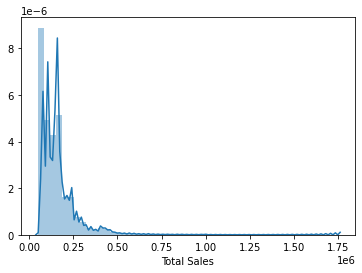

In [100]:
c = so.groupby('SO Number')['Total Sales'].sum()
under150= c[c<150000]
sns.distplot(c)

In [101]:
len(under150)/len(c)*100

59.01598463715489

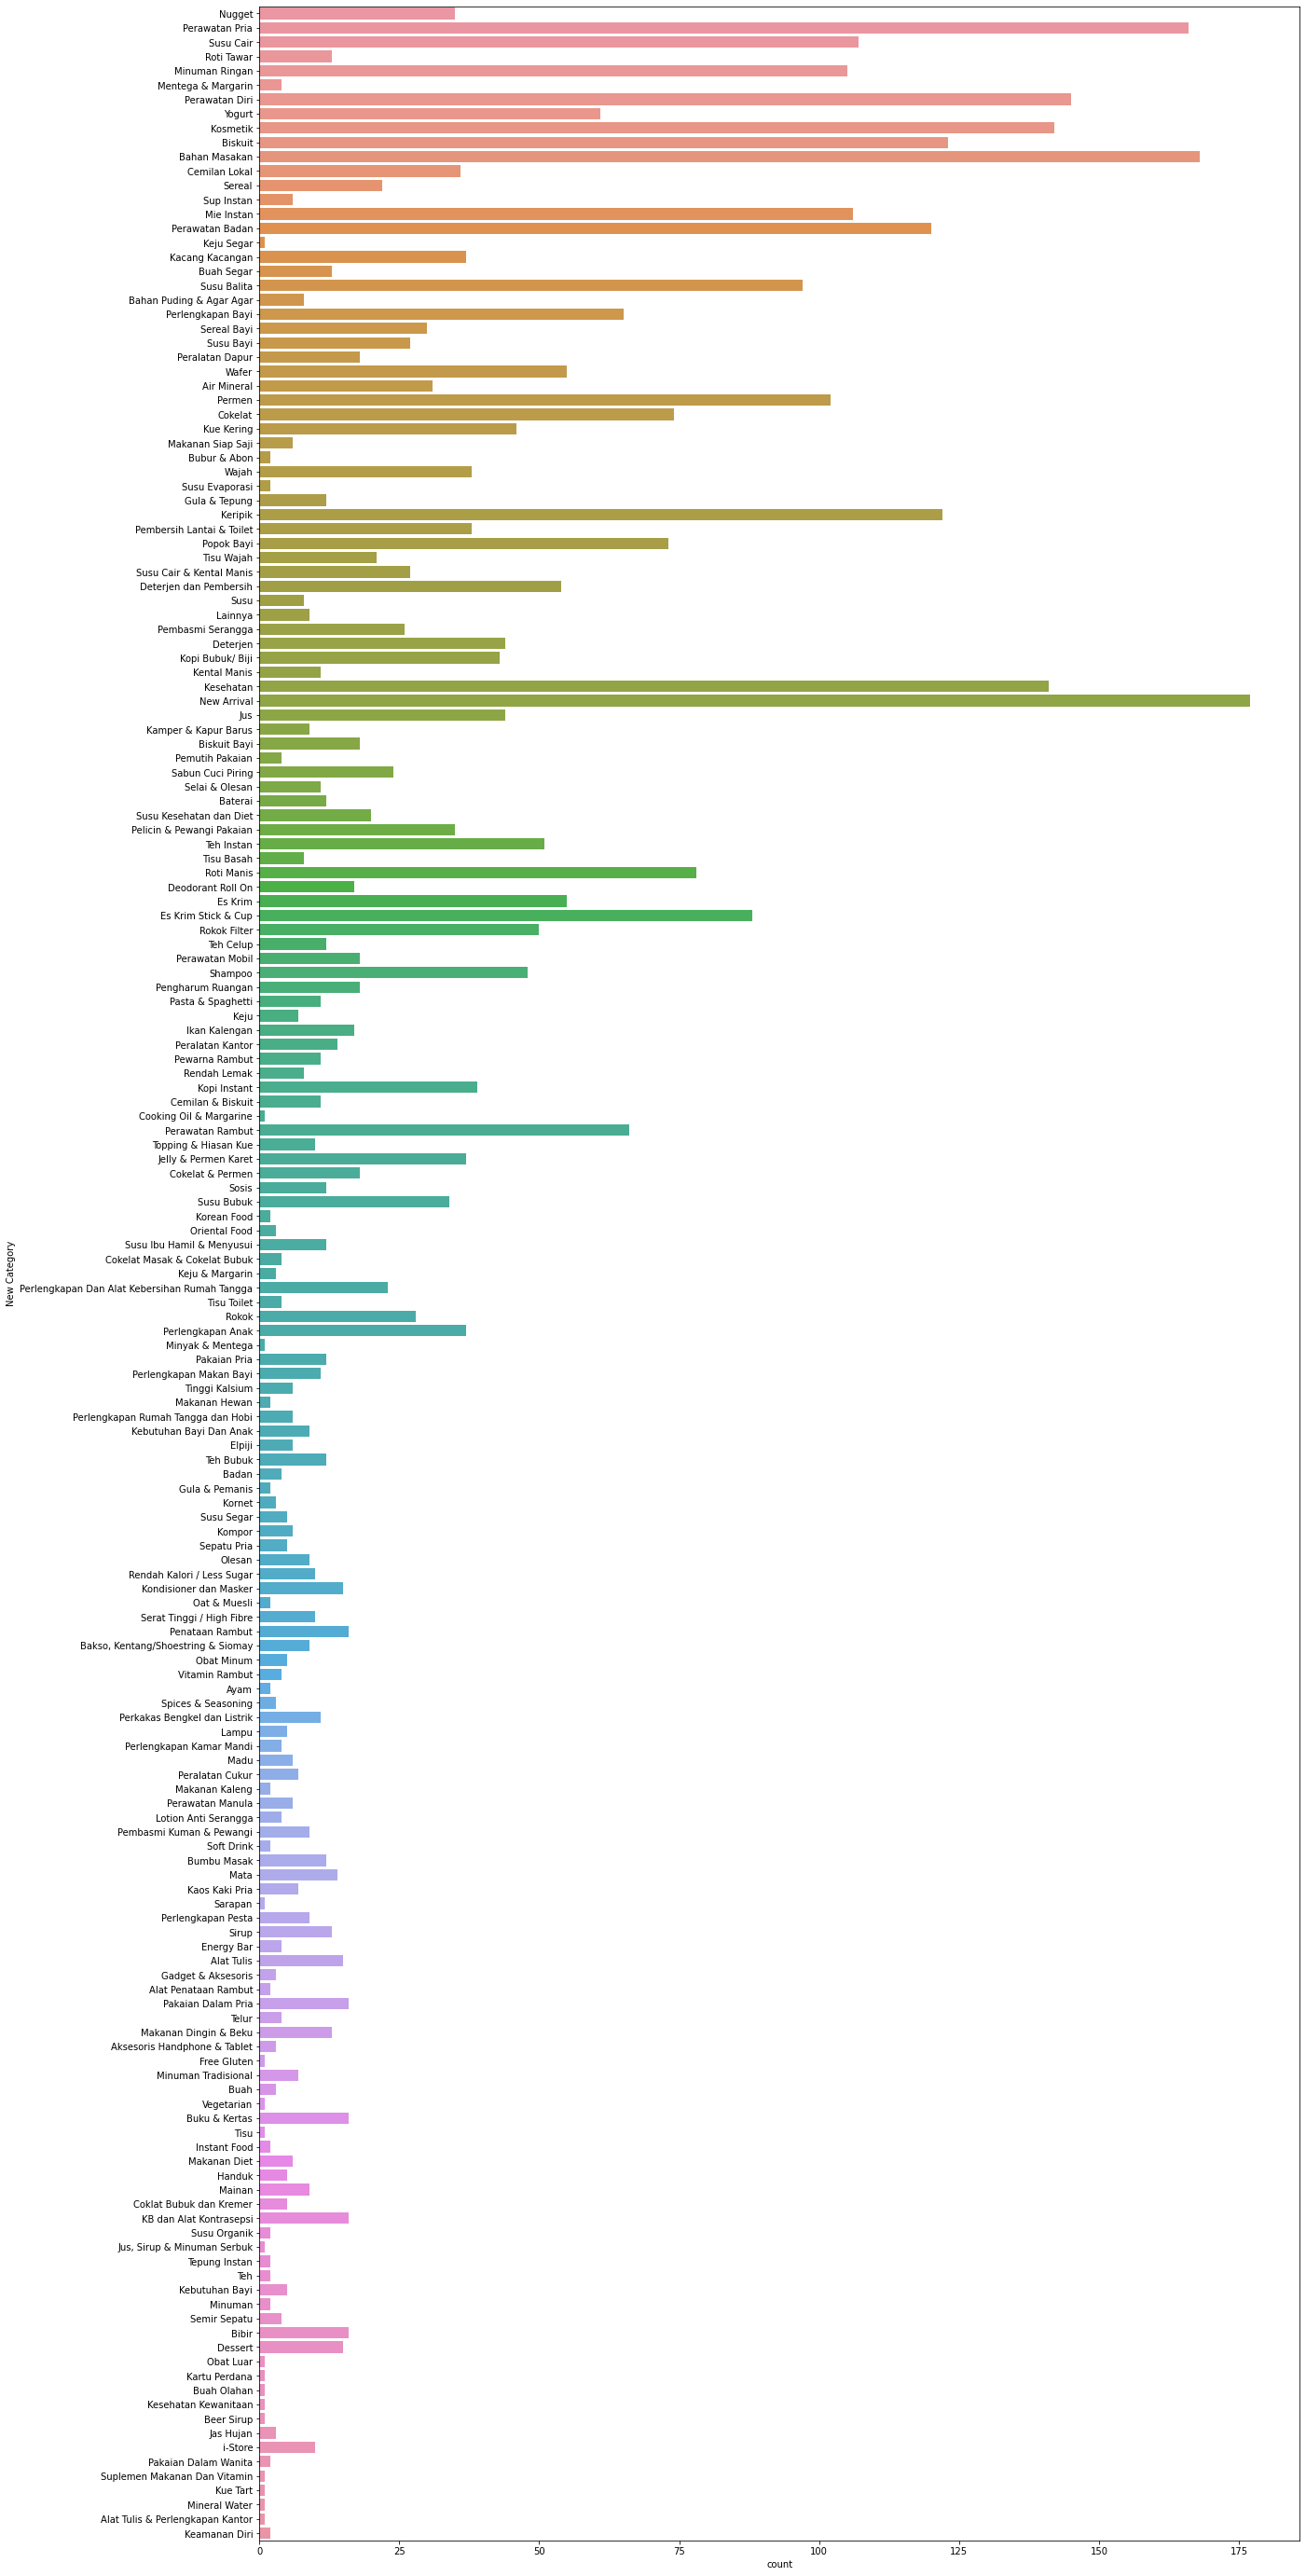

In [102]:
plt.figure(figsize=(20,50))
sns.countplot(y="New Category", data=master,orient="v")

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53]), <a list of 54 Text major ticklabel objects>)

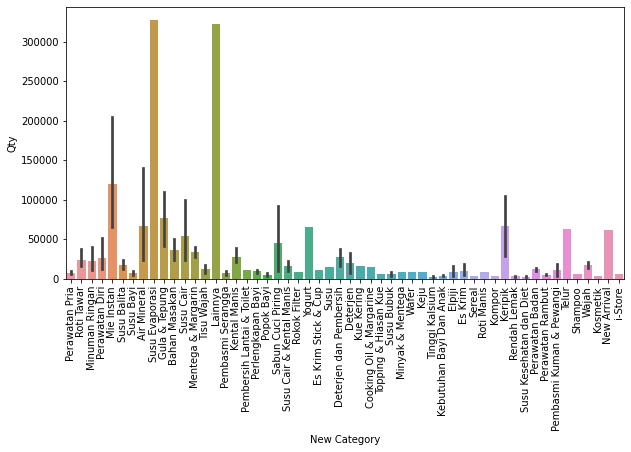

In [114]:
plt.figure(figsize=(10,5))
sns.barplot(x="New Category", y="Qty", data=master[master['Total Sales']>150000000],orient="v")
plt.xticks(rotation=90)

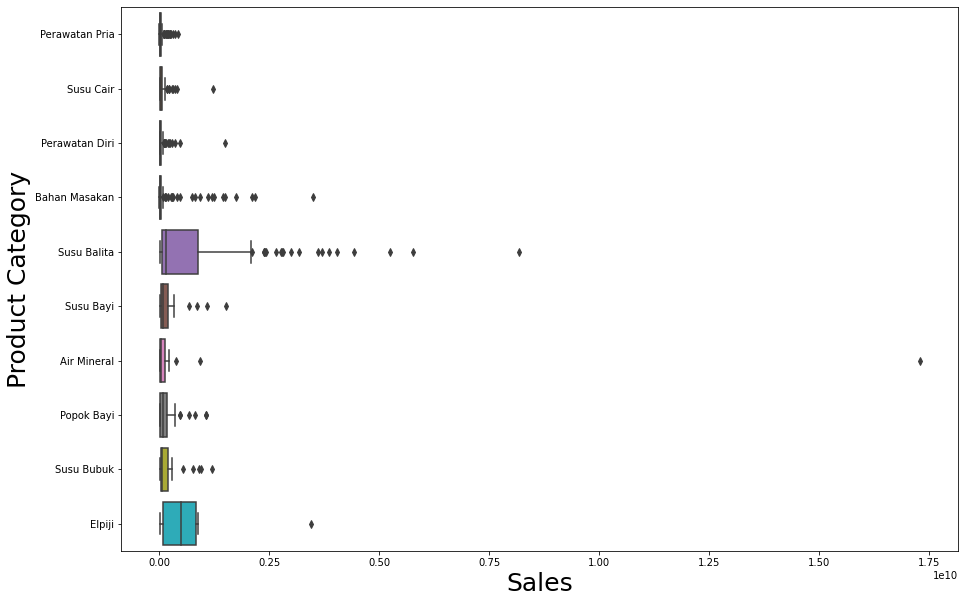

In [131]:
desc = master.groupby(['New Category'])['Total Sales'].sum().sort_values(ascending=False).iloc[0:10].index
fig= plt.figure(figsize=(15,10))
sns.boxplot(data=master[master['New Category'].isin(desc)], x='Total Sales', y='New Category',orient="h")
plt.xlabel('Sales',fontsize=25)
plt.ylabel('Product Category',fontsize=25)
fig.savefig('Boxplot.png')

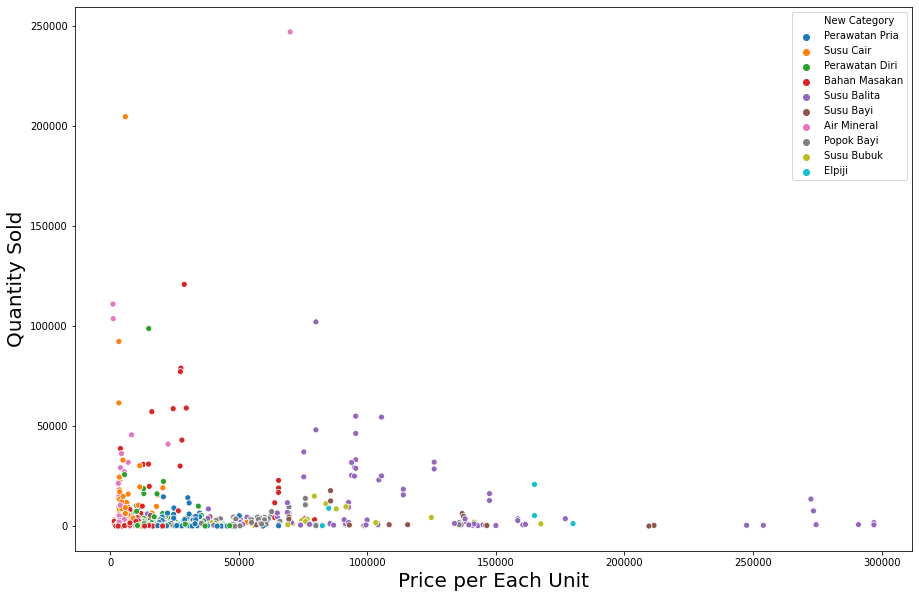

In [130]:
desc = master.groupby(['New Category'])['Total Sales'].sum().sort_values(ascending=False).iloc[0:10].index
fig= plt.figure(figsize=(15,10))
sns.scatterplot(data=master[master['New Category'].isin(desc)], x='Sales (Harga Jual)', y='Qty',hue ='New Category')
plt.xlabel('Price per Each Unit', fontsize=20)
plt.ylabel('Quantity Sold',fontsize=20)
fig.savefig('scatterplot.png')

# Making lists of Items which contributing to 80% of Total Sales per Category

In [104]:
pareto = {}
items_by_category = {}
for i in so['New Category'].unique():
    res = pd.DataFrame()
    Deskripsi = []
    sls = []
    temp_1 = so[so['New Category']==i]
    for j in temp_1['Deskripsi'].unique():
        temp_2 = temp_1[temp_1['Deskripsi']==j]['Total Sales']
        Deskripsi.append(j)
        sls.append(int(temp_2.sum()))
    res['Deskripsi'] = Deskripsi 
    res['Sales'] = sls
    res['%'] = res['Sales']/res['Sales'].sum()*100
    res= res.sort_values('%',ascending=False).reset_index(drop=True)
    res['cum'] = res['%'].cumsum()
    res['pareto'] = res['cum']<80
    idx = (res[res['cum']<80].index.max())+2
    if len(temp_1['Deskripsi'].unique())<idx:
        idx=len(temp_1['Deskripsi'].unique())
    if idx > 1 and idx < 3 :
        pareto[i] = res.iloc[:idx,0].to_list()
    elif idx>=3:
        pareto[i] = res.iloc[:3,0].to_list()
    else :
        pareto[i] = list(res.iloc[0,0])
    items_by_category[i] = res.iloc[:,0].to_list()
# print(pareto)
# print(items_by_category)

# Now it is ready, let's make Baseline Model

In [105]:
df = so.copy()

In [106]:
basket = (df.groupby(['SO Number', 'New Category'])['Qty']
          .sum().unstack().reset_index().fillna(0)
          .set_index('SO Number'))
basket

New Category,Air Mineral,Aksesoris Handphone & Tablet,Alat Penataan Rambut,Alat Tulis,Alat Tulis & Perlengkapan Kantor,Ayam,Badan,Bahan Masakan,Bahan Puding & Agar Agar,"Bakso, Kentang/Shoestring & Siomay",...,Tisu Basah,Tisu Toilet,Tisu Wajah,Topping & Hiasan Kue,Vegetarian,Vitamin Rambut,Wafer,Wajah,Yogurt,i-Store
SO Number,,,,,,,,,,,,,,,,,,,,,
A1167005Y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A116700B7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A116700CG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A116700G8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
A116700JI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A1V87ZZQA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1V87ZZRT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1V87ZZU9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [107]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1
basket_sets = basket.applymap(encode_units)

In [108]:
frequent_itemsets = apriori(basket_sets, min_support=0.015, use_colnames=True)
rules_baseline = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules_baseline

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Air Mineral),(Keripik),0.107964,0.083594,0.015747,0.145855,1.744803,0.006722,1.072893
1,(Keripik),(Air Mineral),0.083594,0.107964,0.015747,0.188376,1.744803,0.006722,1.099075
2,(Air Mineral),(Mie Instan),0.107964,0.093366,0.015856,0.146861,1.572954,0.005775,1.062703
3,(Mie Instan),(Air Mineral),0.093366,0.107964,0.015856,0.169822,1.572954,0.005775,1.074512
4,(Biskuit),(Bahan Masakan),0.067781,0.300335,0.026687,0.393727,1.310961,0.006330,1.154044
...,...,...,...,...,...,...,...,...,...
73,(Perawatan Badan),(Perawatan Diri),0.059735,0.101152,0.015384,0.257544,2.546096,0.009342,1.210641
74,(Perawatan Badan),(Perawatan Pria),0.059735,0.084076,0.019116,0.320010,3.806190,0.014094,1.346966
75,(Perawatan Pria),(Perawatan Badan),0.084076,0.059735,0.019116,0.227364,3.806190,0.014094,1.216956
76,(Perawatan Diri),(Perawatan Pria),0.101152,0.084076,0.024507,0.242279,2.881662,0.016003,1.208788


In [109]:
rules_baseline.describe()

,antecedent support,consequent support,support,confidence,lift,leverage,conviction
count,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000
mean,0.131279,0.131279,0.022189,0.266586,2.879200,0.009931,1.227109
std,0.105278,0.105278,0.009088,0.157720,3.253794,0.004961,0.270628
min,0.023129,0.023129,0.015036,0.050065,1.095439,0.002458,1.008990
25%,0.059735,0.059735,0.015913,0.147681,1.410590,0.005862,1.061638
50%,0.084076,0.084076,0.017703,0.233292,1.700287,0.009342,1.166713
75%,0.300335,0.300335,0.026367,0.407061,2.783873,0.013375,1.278247
max,0.300335,0.300335,0.050237,0.662026,20.427559,0.020954,2.862914


# Feature Engineering

In [110]:
so['Month'] = pd.DatetimeIndex(so['Transaction Date']).month
so['Day'] = pd.DatetimeIndex(so['Transaction Date']).day_name()

In [111]:
so.columns

Index(['SO Number', 'Transaction Date', 'Sales (Harga Jual)',
       'Web Payment Status', 'Total Sales', 'Kode Motherstore', 'PLU',
       'Deskripsi', 'Qty', 'Find', 'Name', 'Level', 'New Category', 'Month',
       'Day'],
      dtype='object')

In [112]:
store = pd.DataFrame()
so.rename(columns={'Kode Motherstore':'Kode MS'},inplace=True)
store['Kode MS'] = so['Kode MS'].unique()

In [113]:
def rp (x):
    a = so[so['Kode MS']==x['Kode MS']].groupby('SO Number').sum()['Total Sales']
    return a.max(),a.mean()

def qty (x):
    a = so[so['Kode MS']==x['Kode MS']].groupby('SO Number').sum()['Qty']
    return a.max(),a.mean()

def spdqty (x):
    a = so[so['Kode MS']==x['Kode MS']].groupby('Transaction Date').sum()['Qty']
    return a.sum()/len(so['Transaction Date'].unique())

def spdrp (x):
    a = so[so['Kode MS']==x['Kode MS']].groupby('Transaction Date').sum()['Total Sales']
    return a.sum()/len(so['Transaction Date'].unique())

def unique_items (x):
    a = so[so['Kode MS']==x['Kode MS']]['PLU'].nunique()
    return a

def day_breakout(x):
    a = so[so['Kode MS']==x['Kode MS']].groupby('Day')['Qty'].mean()
    return np.argmax(a),a.max(),np.argmin(a),a.min(),a.nunique()

def month_active(x):
    a = so[so['Kode MS']==x['Kode MS']].groupby('Month')['Qty'].mean()
    return a.nunique()
    
store[['Max Rp','APC Rp']]= store.apply(rp, axis=1,result_type='expand')
store[['Max Qty.','APC Qty.']] = store.apply(qty ,axis=1,result_type='expand')
store['SPD Qty']= store.apply(spdqty, axis=1)
store['SPD Rp']= store.apply(spdrp, axis=1)
store['Unique Items'] = store.apply(unique_items,axis=1)
store[['Day of Daily Max Avg','Daily Max Avg',' Day of Daily Min Avg','Daily Min Avg', 'Day Active']] = store.apply(day_breakout,axis=1,result_type='expand')
store['Month Active']=store.apply(month_active,axis=1)

# Clustering Mother Store

In [115]:
X = store.copy()
y = X[['Kode MS']]
X.drop('Kode MS',axis=1,inplace=True)

In [116]:
y

,Kode MS
0,TWNC
1,TJK8
2,THIJ
3,TM5D
4,TIMX
...,...
1915,THTT
1916,TUU1
1917,TX68
1918,TVVW


In [117]:
Numeric = ['Max Rp', 'APC Rp', 'Max Qty.', 'APC Qty.', 'SPD Qty', 'SPD Rp','Unique Items','Daily Max Avg','Daily Min Avg']
Categoric = ['Day of Daily Max Avg', ' Day of Daily Min Avg', 'Day Active', 'Month Active'] 

In [118]:
scaler = MinMaxScaler()
scaler_transformer = scaler.fit(X[Numeric])
X_scaled = scaler_transformer.transform(X[Numeric])
X_scaled = pd.DataFrame (X_scaled,columns = Numeric)
X.drop(Numeric,axis=1,inplace=True)
X
X = pd.concat([X,X_scaled],axis=1)

In [119]:
X = pd.get_dummies(data = X, drop_first = True, columns = Categoric)
X

,Max Rp,APC Rp,Max Qty.,APC Qty.,SPD Qty,SPD Rp,Unique Items,Daily Max Avg,Daily Min Avg,Day of Daily Max Avg_Monday,...,Day of Daily Min Avg_Tuesday,Day of Daily Min Avg_Wednesday,Day Active_2,Day Active_3,Day Active_4,Day Active_5,Day Active_6,Day Active_7,Month Active_2,Month Active_3
0,0.733816,0.419875,0.057275,0.151113,0.149102,0.150875,0.500860,0.052827,0.042888,0,...,0,0,0,0,0,0,0,1,1,0
1,0.553967,0.402665,0.033289,0.180740,0.323476,0.273006,0.729274,0.033169,0.039730,0,...,0,0,0,0,0,0,0,1,0,1
2,0.618423,0.490459,0.057971,0.094313,0.341856,0.564972,0.695562,0.035328,0.048659,0,...,0,0,0,0,0,0,0,1,0,1
3,0.720339,0.384384,0.032530,0.168908,0.323936,0.280853,0.783282,0.032945,0.046275,0,...,0,0,0,0,0,0,0,1,0,1
4,0.811146,0.396655,0.064363,0.156302,0.221783,0.209807,0.495012,0.063365,0.034990,0,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,0.079331,0.509390,0.000949,0.211984,0.000246,0.000176,0.004128,0.005255,0.015385,1,...,0,0,0,0,0,0,0,0,0,0
1916,0.036782,0.199335,0.000506,0.091860,0.000246,0.000203,0.004128,0.005255,0.015385,1,...,0,0,0,0,0,0,0,0,0,0
1917,0.013183,0.084646,0.000253,0.056529,0.000066,0.000029,0.001032,0.008539,0.025000,1,...,0,0,0,0,0,0,0,0,0,0
1918,0.044256,0.284170,0.000063,0.014132,0.000016,0.000098,0.000688,0.000000,0.000000,1,...,0,0,0,0,0,0,0,0,0,0


([<matplotlib.axis.XTick at 0x1894e642c08>,
 <a list of 10 Text major ticklabel objects>)

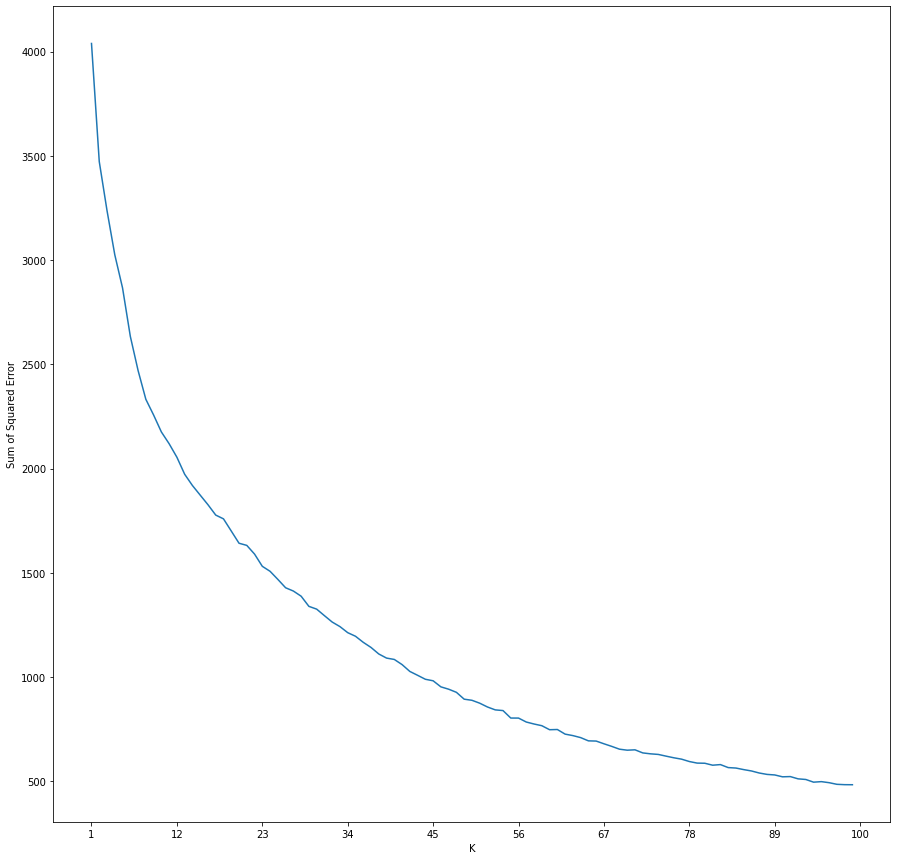

In [120]:
k_rng = range(1,100)
sse = []
for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(X)
    sse.append(km.inertia_)

plt.figure(figsize=(15,15))
plt.xlabel('K')
plt.ylabel('Sum of Squared Error')
plt.plot(k_rng,sse)
plt.xticks(np.linspace(1,100,10))

In [121]:
num_of_clusters = 50
km = KMeans(n_clusters=num_of_clusters,random_state=83)
y['Cluster'] = km.fit_predict(X)

In [122]:
so = so.merge(y,on='Kode MS',how='left')

In [123]:
y.set_index('Kode MS',drop=True,inplace=True)

# K - Apriori Algorithm

In [124]:
rules = {}

def item_pair(x):
    ant = []
    con = []
    for i in x['antecedents']:
        for j in items_by_category[i]:
            ant.append(j)
    for k in x['consequents']:
        for l in pareto[k]:
            con.append(l)
    return (ant,con)

for i in range(0,num_of_clusters):
    df = so[so['Cluster']==i]
    basket = (df.groupby(['SO Number', 'New Category'])['Qty']
          .sum().unstack().reset_index().fillna(0)
          .set_index('SO Number'))
    basket_sets = basket.applymap(encode_units)
    frequent_itemsets = apriori(basket_sets, min_support=0.02, use_colnames=True)
    asso = association_rules(frequent_itemsets,metric="lift", min_threshold=1)
    asso[['item_antecedent','item_consequent']]=asso.apply(item_pair,axis=1,result_type='expand')
    rules[i] = asso


# Dumping

In [125]:
joblib.dump(rules, 'rules')
joblib.dump(y, 'MS')


['MS']

In [126]:
joblib.dump(master,'master')
joblib.dump(so.sample(25),'sample')

['sample']

In [135]:
so.columns

Index(['SO Number', 'Transaction Date', 'Sales (Harga Jual)',
       'Web Payment Status', 'Total Sales', 'Kode MS', 'PLU', 'Deskripsi',
       'Qty', 'Find', 'Name', 'Level', 'New Category', 'Month', 'Day',
       'Cluster'],
      dtype='object')

# Making Recommendations

In [127]:
cart_price=0
def rec (kodetoko,cart):
    while cart.count('')>0:
        cart.remove('')
    clst = y.at[kodetoko,'Cluster']
    temp = rules[clst]
    global cart_price 
    cart_price = 0
    list_rec = []
    for i in cart :
        cart_price += (master[master['Deskripsi']==i].iloc[0,1])
        for j in range(len(temp)):
            if i in temp['item_antecedent'][j]:
                list_rec+=(temp['item_consequent'][j])
    print(cart_price)
    list_desk = []
    list_price = []
    for i in list_rec:
            if i in cart:
                pass
            else :
                list_desk.append(i)
                list_price.append(master[master['Deskripsi']==i].iloc[0,1])
    df_rec = pd.DataFrame()
    df_rec['Deskripsi']=list_desk
    df_rec['Sales (Harga Jual)']=list_price
    df_rec['Sales (Harga Jual)'] = df_rec['Sales (Harga Jual)'].astype(int)
    df_rec = shuffle(df_rec)
    df_rec.reset_index(drop=True)
    if len(df_rec)>10:
        desk = df_rec.iloc[:10,0]
        harga = df_rec.iloc[:10,1]
    else : 
        desk = df_rec.iloc[:,0]
        harga = df_rec.iloc[:,1]
    return list(zip(desk,harga))

In [128]:
len(rec('T001',['Bimoli,Minyak Goreng (Refill)  2000Ml Pch','Rose Brand,Gula Pasir Kuning 1Kg Pck','Lifebuoy,Sabun Mandi Cair Refill Lemon Fresh 450Ml Pch']))

72000.0


10

In [129]:
rec

<function __main__.rec(kodetoko, cart)>